# Datasets (Sentiment)

## IMDB

- http://ai.stanford.edu/~amaas/data/sentiment/

&rarr; **BAD** - only single pos + neg review for each film

- https://www.imdb.com/interfaces/

&rarr; no review text!

## Yelp

- https://www.yelp.com/dataset/documentation/main

In [ ]:
! pip install jsonlines

[]

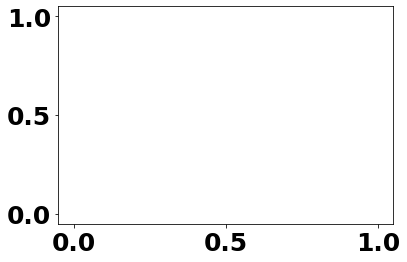

In [1]:
import os
import random
import pickle
from collections import Counter
from pathlib import Path

import jsonlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import set_matplotlib_formats
from tqdm import tqdm

random.seed(42)
np.random.seed(42)

tqdm.pandas()

%matplotlib inline
plt.rcParams.update({"font.size": 25, "font.weight": "bold"})
# https://stackoverflow.com/questions/36622237/jupyter-notebook-inline-plots-as-svg
# set_matplotlib_formats("svg")  # glitches it
plt.plot()

In [ ]:
from utils_data import init_random
init_random()

In [2]:
# download + scp to cuda + extract
data_yelp_path = Path("/home/ekoerner/same-side-classification/data/sentiment/yelp/")

In [3]:
fn_yelp_reviews = data_yelp_path / "review.json"

data = list()

with jsonlines.open(fn_yelp_reviews, "r") as fp:
    for n, entry in enumerate(tqdm(fp)):
        # print(entry)
        # break
        business_id = entry.pop("business_id")
        review_id = entry.pop("review_id")
        text = entry.pop("text", "")
        rating = entry.pop("stars", 0.0)
        data.append({"id": business_id, "rid": review_id, "text": text, "rating": rating})
        # TESTING
        # if n > 10000:
        #     break
        
df = pd.DataFrame.from_dict(data)

6685900it [00:48, 137163.13it/s]


In [4]:
fn_yelp_topics = data_yelp_path / "business.json"

inv_bid_cats = dict()
inv_cat_bids = dict()
bids_not_cats = set()


# load lookup business -> categories
with jsonlines.open(fn_yelp_topics, "r") as fp:
    for n, entry in enumerate(tqdm(fp)):
        business_id = entry.pop("business_id")
        categories = entry.pop("categories")

        if not categories:
            bids_not_cats.add(business_id)
            continue

        categories = categories.split(", ")

        inv_bid_cats[business_id] = categories

# reverse lookup: category -> businesses
for bid, cats in tqdm(inv_bid_cats.items()):
    for cat in cats:
        try:
            inv_cat_bids[cat].append(bid)
        except KeyError:
            inv_cat_bids[cat] = [bid]

192609it [00:02, 73694.20it/s]
100%|██████████| 192127/192127 [00:00<00:00, 861900.50it/s]


In [5]:
# Add goodness value
# TODO: maybe ignore with 3
df["goodness"] = df["rating"] > 3

#### Statistics

In [6]:
print(f"Number of businesses with categories: {len(inv_bid_cats):>6}")
print(f"                  without categories: {len(bids_not_cats):>6}")
print(f"Number of categories: len(inv_cat_bids) = {len(inv_cat_bids)}")

Number of businesses with categories: 192127
                  without categories:    482
Number of categories: len(inv_cat_bids) = 1300


In [7]:
# make combinations with amount
inv_cat_combis = Counter()

inv_cat_combis.update(
    (tuple(sorted(set(cats))) for cats in tqdm(inv_bid_cats.values())))

100%|██████████| 192127/192127 [00:00<00:00, 284411.51it/s]


In [8]:
inv_cat_combis.most_common(20)

[(('Pizza', 'Restaurants'), 2035),
 (('Apartments', 'Home Services', 'Real Estate'), 1978),
 (('Beauty & Spas', 'Nail Salons'), 1978),
 (('Coffee & Tea', 'Food'), 1753),
 (('Mexican', 'Restaurants'), 1738),
 (('Beauty & Spas', 'Hair Salons'), 1650),
 (('Chinese', 'Restaurants'), 1629),
 (('Event Planning & Services', 'Hotels', 'Hotels & Travel'), 1426),
 (('Auto Repair', 'Automotive'), 1119),
 (('Food', 'Grocery'), 983),
 (('Italian', 'Restaurants'), 920),
 (('Burgers', 'Fast Food', 'Restaurants'), 885),
 (('Banks & Credit Unions', 'Financial Services'), 840),
 (('Fast Food', 'Restaurants', 'Sandwiches'), 800),
 (('Food', 'Ice Cream & Frozen Yogurt'), 781),
 (('Barbers', 'Beauty & Spas'), 745),
 (('Italian', 'Pizza', 'Restaurants'), 677),
 (('Auto Repair', 'Automotive', 'Oil Change Stations', 'Tires'), 635),
 (('Japanese', 'Restaurants', 'Sushi Bars'), 619),
 (('Dry Cleaning & Laundry', 'Laundry Services', 'Local Services'), 612)]

In [9]:
# count single categories
cnt = Counter({k: len(v) for k, v in inv_cat_bids.items()})
cnt.most_common(20)

[('Restaurants', 59371),
 ('Shopping', 31878),
 ('Food', 29989),
 ('Home Services', 19729),
 ('Beauty & Spas', 19370),
 ('Health & Medical', 17171),
 ('Local Services', 13932),
 ('Automotive', 13203),
 ('Nightlife', 13095),
 ('Bars', 11341),
 ('Event Planning & Services', 10371),
 ('Active Life', 9521),
 ('Fashion', 7798),
 ('Sandwiches', 7332),
 ('Coffee & Tea', 7321),
 ('Fast Food', 7257),
 ('American (Traditional)', 7107),
 ('Hair Salons', 6955),
 ('Pizza', 6804),
 ('Home & Garden', 6489)]

In [10]:
# Check for subgraphs naive

## build mapping for occurrence of each categories with other categories
map_cat_cats = dict()

for cats in tqdm(inv_bid_cats.values()):
    for cat in cats:
        try:
            map_cat_cats[cat].update(cats)
        except KeyError:
            map_cat_cats[cat] = set(cats)

cnt_cat_cats = Counter({cat: len(cats) for cat, cats in tqdm(map_cat_cats.items())})
            
set_all_cats = set(map_cat_cats.keys())

100%|██████████| 1300/1300 [00:00<00:00, 1701277.75it/s]


In [11]:
print(f"Number of all cats: {len(set_all_cats)}")
cnt_cat_cats.most_common(20)

Number of all cats: 1300


[('Shopping', 993),
 ('Local Services', 870),
 ('Event Planning & Services', 826),
 ('Professional Services', 800),
 ('Active Life', 782),
 ('Restaurants', 761),
 ('Arts & Entertainment', 740),
 ('Home Services', 736),
 ('Food', 731),
 ('Education', 671),
 ('Health & Medical', 645),
 ('Nightlife', 614),
 ('Hotels & Travel', 589),
 ('Beauty & Spas', 558),
 ('Local Flavor', 549),
 ('Home & Garden', 542),
 ('Automotive', 541),
 ('Fashion', 533),
 ('Specialty Schools', 517),
 ('Venues & Event Spaces', 502)]

##### search for smallest any-connected subgraph ?

merge all groups of related categories to find any two groups that are fully distinct over n edges

In [12]:
## Try to compute distinct sub groups of categories
inv_cat_group_id = dict()  # Dict[str, int]
lst_cat_subgroups = list()  # List[List[str]]  # TODO: better Dict[int, Set[str]]

def _has_related_cat_in_group_already(cat):
    for rcat in map_cat_cats[cat]:
        if rcat in inv_cat_group_id:
            return True
    return False

def _find_related_cat_groups(cat):
    rcat_groups = list()
    for rcat in map_cat_cats[cat]:
        gid = inv_cat_group_id.get(rcat, None)
        if gid is not None:
            rcat_groups.append((rcat, gid))
    return rcat_groups

def _trim_group_ids():
    # search for empty groups (None or empty set)
    lst_shifting = list()
    for n, ele in enumerate(lst_cat_subgroups):
        if not ele:
            lst_shifting.append(n)

    if not lst_shifting:
        return

    # move larger current groups over empty groups with lower id
    for cat, old_gid in inv_cat_group_id.items():
        new_gid = old_gid
        for n in lst_shifting:
            if n < new_gid:
                # empty group before current group id,
                # reduce current group id (--> skip empty group)
                new_gid -= 1
        # update on change (check should not really matter)
        if new_gid != old_gid:
            inv_cat_group_id[cat] = new_gid

    for n in reversed(lst_shifting):
        del lst_cat_subgroups[n]

def _merge_related_cat_groups(cat, target_gid=None):
    if target_gid is None:
        # find first best gid
        # (a) check category
        target_gid = inv_cat_group_id.get(cat, None)
        # (b) check related categories
        if target_gid is None:
            for rcat in map_cat_cats[cat]:
                target_gid = inv_cat_group_id.get(rcat, None)
                if target_gid is not None:
                    break

    if target_gid is None:
        print(f"No category to merge for {cat}!")
        return

    # search for different group ids in related categories of cat
    set_old_gid = set()
    for rcat in map_cat_cats[cat]:
        other_gid = inv_cat_group_id.get(rcat, None)
        if other_gid is not None and other_gid != target_gid:
            set_old_gid.add(other_gid)

    # add non group related categories to target group
    for rcat in map_cat_cats[cat]:
        if rcat not in inv_cat_group_id:
            inv_cat_group_id[rcat] = target_gid
            lst_cat_subgroups[target_gid].add(rcat)

    # rewrite other group ids to target group id
    if not set_old_gid:
        return

    # rewrite inverse cat-gid mapping, empty old groups
    for old_gid in set_old_gid:
        old_rcats = lst_cat_subgroups[old_gid]
        for old_rcat in old_rcats:
            inv_cat_group_id[old_rcat] = target_gid
        lst_cat_subgroups[old_gid] = None

    _trim_group_ids()

# -----
            
for cat, _ in cnt_cat_cats.most_common(None):
    if cat in inv_cat_group_id:
        # an existing group has this category already
        # merge groups from related categories together
        # additionally add new elements to target group (merged group)
        _merge_related_cat_groups(cat)
        _trim_group_ids()
    else:
        # new group possible
        print(f"new group?: {cat}")
        if not _has_related_cat_in_group_already(cat):
            # open new group
            gid = len(lst_cat_subgroups)
            rcats = map_cat_cats[cat]
            lst_cat_subgroups.append(set(rcats))
            for icat in rcats:
                inv_cat_group_id[icat] = gid
        else:
            # merge groups
            _merge_related_cat_groups(cat)
            _trim_group_ids()

new group?: Shopping


In [13]:
print(f"Number of distinct groups: {len(lst_cat_subgroups)}")
print(f"Number of elements in first group: {len(lst_cat_subgroups[0])}")
print(f"Number of all categories: {len(set_all_cats)}")

Number of distinct groups: 1
Number of elements in first group: 1300
Number of all categories: 1300


##### search for main groups 

groups can share related categories but can no directly appear together:  
`{A, b} - {C, b}` -- ok, `C` and `A` are not together but share related elements  
`{A, b, C} - {C, b}` -- not ok, as `C` is with `A`

In [14]:
lst_cat_dist_candidates = [cat for cat, _ in cnt_cat_cats.most_common(None)]
# TODO: maybe random shuffle of candidates?
set_cats_distinct = set()

# lst_cat_dist_candidates.pop(0)

while lst_cat_dist_candidates:
    cat = lst_cat_dist_candidates.pop(0)
    set_cats_distinct.add(cat)

    # remove directly related categories, i.e. categories that appear together
    # TODO: maybe compute frequency of co-occurrence of categories and make a cut-off???
    for rcat in map_cat_cats[cat]:
        try:
            lst_cat_dist_candidates.remove(rcat)
        except ValueError:
            # element not in list anymore
            pass

In [15]:
print(
    f"Number of distinct categories (starting from the largest): {len(set_cats_distinct)}"
)
cnt_dist_cats = Counter({
    cat: cnt
    for cat, cnt in cnt_cat_cats.most_common(None) if cat in set_cats_distinct
})
cnt_dist_cats.most_common(20)

Number of distinct categories (starting from the largest): 177


[('Shopping', 993),
 ('Soul Food', 105),
 ('Noodles', 104),
 ('Hawaiian', 99),
 ('German', 94),
 ('Public Transportation', 87),
 ('Personal Injury Law', 70),
 ('Campgrounds', 70),
 ('Brazilian', 69),
 ('Irish', 66),
 ('Osteopathic Physicians', 59),
 ('Zoos', 58),
 ('Afghan', 54),
 ('Home & Rental Insurance', 53),
 ('Argentine', 53),
 ('Ethiopian', 50),
 ('New Mexican Cuisine', 49),
 ('Pet Boarding', 47),
 ('Brewpubs', 47),
 ('Language Schools', 46)]

maybe start with any element / or with random sorting (shuffled) N times and select the minimum length result or with the best mean/avg value?

##### search for distinct groups but just with no element intersection

In [16]:
lst_cat_dist_candidates = [cat for cat, _ in cnt_cat_cats.most_common(None)]
# TODO: maybe random shuffle of candidates?
set_cats_distinct = set()

# [lst_cat_dist_candidates.pop(0) for _ in range(1)]

while lst_cat_dist_candidates:
    cat = lst_cat_dist_candidates.pop(0)
    set_cats_distinct.add(cat)

    # remove directly related categories, i.e. categories that appear together
    # TODO: maybe compute frequency of co-occurrence of categories and make a cut-off???
    for rcat in map_cat_cats[cat]:
        try:
            lst_cat_dist_candidates.remove(rcat)
        except ValueError:
            # element not in list anymore
            pass

    # remove categories that contain a shared related category
    for rcat in map_cat_cats[cat]:
        # for all current related categories
        # check any of the remaining categories
        for ocat in list(lst_cat_dist_candidates):
            # that they contain not any related category as our current one
            if rcat in set(map_cat_cats[ocat]):
                lst_cat_dist_candidates.remove(ocat)

In [17]:
print(
    f"Number of distinct categories (starting from the largest): {len(set_cats_distinct)}"
)
cnt_dist_cats = Counter({
    cat: cnt
    for cat, cnt in cnt_cat_cats.most_common(None) if cat in set_cats_distinct
})
cnt_dist_cats.most_common(20)

Number of distinct categories (starting from the largest): 1


[('Shopping', 993)]

#### Test / Playground

In [ ]:
# exceprt
df  # .count()

In [ ]:
# ratings info
df.describe()

In [ ]:
# how many reviews per business (id)
df.groupby("id").count()[["rating"]].describe()

In [ ]:
# def fn_goodness(row):
#     row["good"] = True if row["rating"].value >= 2.5 else False
#     return row

# try:
#     df = df.progress_apply(fn_goodness, axis=1)
# except AttributeError:
#     df = df.apply(fn_goodness)

# set good if more than 3 in rating
df["goodness"] = df["rating"] > 3

In [ ]:
df.groupby(["goodness", "id"]).count()

In [ ]:
# select only those that have more than N reviews
df.groupby(["id", "goodness"])[["id"]].count() > 3

In [ ]:
# select only those IDs that contain both pos + negative reviews
df.groupby(["id", "goodness"], as_index=False).count().groupby("id")[["id"]].count() == 2

In [ ]:
len(df), len(df[df["rating"] == 3])

In [ ]:
inv_bid_cats[list(inv_bid_cats.keys())[0]]

In [18]:
df.groupby(["rating"], ).count()[["id"]]

,id
rating,
1.0,1002159
2.0,542394
3.0,739280
4.0,1468985
5.0,2933082


#### Filter reviews with at least N ratings

In [ ]:
# min ratings per class (good|bad)
min_ratings = 5

In [ ]:
# filter with at least N ratings per goodness
df_filter = df.groupby(["id", "goodness"])[["id"]].count() < min_ratings
df_filter = df_filter.rename(columns={"id": "filter"})
df_filter = df_filter[df_filter["filter"] == True]

# build a filter id list
df_filter_list = df_filter.reset_index()["id"].to_list()

# filter with list
df_filtered = df[~df.id.isin(df_filter_list)]

In [ ]:
df = df_filtered

#### Filter only reviews with both good and bad rating

In [ ]:
# build filter for ids that contain both positive and negative samples
df_filter = df.groupby(["id", "goodness"], as_index=False).count().groupby("id")[["id"]].count() == 2
df_filter = df_filter.rename(columns={"id": "filter"})
df_filter = df_filter[df_filter["filter"] == True]

# create list of IDs for which this is true
df_filter_list = df_filter.reset_index()["id"].to_list()

# filter with list
df_filtered = df[df.id.isin(df_filter_list)]

# df_filtered
# df_filtered.groupby(["id", "goodness"]).count()

In [ ]:
df = df_filtered

#### Make pairs

**TODO:**

- check similar length -- what strategy to use to combine similar length pairs best?
- flip sides (arg1 <-> arg2)
- make more pairs (?) -- but keep same ratio of same-sentiment vs. not-same-sentiment (different-sentiment) ??
- group by categories (topics) -- more explicit training (uniqueness of single arguments / topic structures)
- evaluate on same-argument (S3C) - or amazon reviews
- compute mean/avg sequence length
- fixed layers in fine-tuning
- visualization of trained layers and activation for good / bad inputs

##### Positive + negative same-sentiment pairs

In [ ]:
num_pairs_per_class = 2
# N positive + N negative
# --> 2N pos+neg (not same-sentiment)

# TODO: randomness for positive ss / negative ss - sum is equal / or sum equal compared to not ss

In [ ]:
pairs_good = list()
pairs_bad = list()

for id_, group in tqdm(df.groupby("id")):
    grouper = group.groupby("goodness")
    reviews_good = grouper.get_group(True)
    reviews_bad = grouper.get_group(False)

    # TESTING
    # print("id:", id_)
    # print("#good:", len(reviews_good))
    # print("#bad:", len(reviews_bad))
    # print(group)
    # break

    # make pairings -- good ss
    rg_idx = reviews_good.index.values
    # print("pos_idx:", rg_idx)
    rg_idx_sel = np.random.choice(rg_idx, 2 * num_pairs_per_class, replace=False)
    for id1, id2 in zip(rg_idx_sel[::2], rg_idx_sel[1::2]):
        # print("pair:", id1, id2)
        r1, r2 = df.loc[id1], df.loc[id2]
        pair = {
            "argument1": r1["text"], "argument2": r2["text"],
            "argument1_id": f"""{r1["id"]}|{r1["rid"]}""", "argument2_id": f"""{r2["id"]}|{r2["rid"]}""",
            "is_same_side": True, "is_good_side": True,
            "topic": inv_bid_cats.get(r1["id"], None)
        }
        # print(pair)
        pairs_good.append(pair)

    # make pairings -- bad ss
    rb_idx = reviews_bad.index.values
    # print("neg_idx:", rb_idx)
    rb_idx_sel = np.random.choice(rb_idx, 2 * num_pairs_per_class, replace=False)
    for id1, id2 in zip(rb_idx_sel[::2], rb_idx_sel[1::2]):
        r1, r2 = df.loc[id1], df.loc[id2]
        pair = {
            "argument1": r1["text"], "argument2": r2["text"],
            "argument1_id": f"""{r1["id"]}|{r1["rid"]}""", "argument2_id": f"""{r2["id"]}|{r2["rid"]}""",
            "is_same_side": True, "is_good_side": False,
            "topic": inv_bid_cats.get(r1["id"], None)
        }
        pairs_bad.append(pair)
        
    # break

In [ ]:
print("#ss (pos)", len(pairs_good))
print("#ss (neg)", len(pairs_bad))

##### not same-sentiment pairs (combinations positive + negative)

In [ ]:
#: number of negative same-sentiment samples same as positive same-sentiment samples
num_pairs_negative = 2 * num_pairs_per_class

#: whether for a single side (good or bad) there can be multiple occurrences of the same review
#: may need to check afterwared that not by chance same pairing happens ...
repeatable_on_side = False

In [ ]:
pairs_not_ss = list()

for id_, group in tqdm(df.groupby("id")):
    grouper = group.groupby("goodness")
    reviews_good = grouper.get_group(True)
    reviews_bad = grouper.get_group(False)

    # find indices for reviews per business
    rg_idx = reviews_good.index.values
    rb_idx = reviews_bad.index.values

    # randomly select from each side
    rg_idx_sel = np.random.choice(rg_idx, num_pairs_negative, replace=repeatable_on_side)
    rb_idx_sel = np.random.choice(rb_idx, num_pairs_negative, replace=repeatable_on_side)
    
    # pair them together -- good-bad pairs
    for idg, idb in zip(rg_idx_sel[::2], rb_idx_sel[::2]):
        rg, rb = df.loc[idg], df.loc[idb]
        pair = {
            "argument1": rg["text"], "argument2": rb["text"],
            "argument1_id": f"""{rg["id"]}|{rg["rid"]}""", "argument2_id": f"""{rb["id"]}|{rb["rid"]}""",
            "is_same_side": False, "is_good_side": None,
            "topic": inv_bid_cats.get(rg["id"], None)
        }
        # print(pair)
        pairs_not_ss.append(pair)
    
    # bad-good pairs
    for idb, idg in zip(rb_idx_sel[1::2], rg_idx_sel[1::2]):
        rb, rg = df.loc[idb], df.loc[idg]
        pair = {
            "argument1": rb["text"], "argument2": rg["text"],
            "argument1_id": f"""{rb["id"]}|{rb["rid"]}""", "argument2_id": f"""{rg["id"]}|{rg["rid"]}""",
            "is_same_side": False, "is_good_side": None,
            "topic": inv_bid_cats.get(rb["id"], None)
        }
        # print(pair)
        pairs_not_ss.append(pair)

In [ ]:
print("#nss", len(pairs_not_ss))

##### dataframe for training etc.

In [ ]:
pairs_all = pairs_good + pairs_bad + pairs_not_ss
print("#~ss", len(pairs_all))

In [ ]:
# print(pairs_all[0]["argument1_id"])
np.random.shuffle(pairs_all)
# print(pairs_all[0]["argument1_id"])

In [ ]:
df_traindev = pd.DataFrame.from_dict(pairs_all)

In [ ]:
fn_yelp_df = data_yelp_path / "df_traindev.p"

with open(fn_yelp_df, "wb") as fp:
    pickle.dump(df_traindev, fp, protocol=pickle.HIGHEST_PROTOCOL)

---

#### Reloading for training

In [ ]:
data_yelp_path = Path("/home/ekoerner/same-side-classification/data/sentiment/yelp/")
fn_yelp_df = data_yelp_path / "df_traindev.p"

with open(fn_yelp_df, "rb") as fp:
    all_df = pickle.load(fp)

In [ ]:
def _add_dummy_tag(row):
    row["tag"] = "NA"
    return row

# all_df = all_df.progress_apply(_add_dummy_tag, axis=1)
all_df["tag"] = "NA"

In [ ]:
num = len(all_df)
ratio = 0.3
idx_ratio = int(num * (1.0 - ratio))
print(f"traindev: [0:{idx_ratio}], test: [{idx_ratio}:{num}], ratio: {ratio}")

traindev_df = all_df.iloc[:idx_ratio]
test_df = all_df.iloc[idx_ratio:]

In [ ]:
# len(traindev_df), len(test_df)

##### Default S3C training

https://gluon-nlp.mxnet.io/install.html

```bash
pip install --upgrade 'mxnet>=1.3.0'  
pip install gluonnlp  
wget https://gluon-nlp.mxnet.io/_downloads/sentence_embedding.zip  
unzip sentence_embedding.zip  
ln -s sentence_embedding/bert bert  
```

In [ ]:
from mxboard import SummaryWriter

from utils_data import get_train_test_sets

from utils_gluon import setup_bert_epi128bce, setup_bert_epi512bce
from utils_gluon import setup_bert_pro128bce, setup_bert_pro512bce

from utils_gluon import transform_dataset
from utils_gluon import predict_out_to_ys

from utils_gluon import predict
from utils_gluon import train

# from utils_gluon import print_infos
from utils_gluon import plot_train_stats

from utils_gluon import report_training_results
from utils_gluon import plot_confusion_matrix

In [ ]:
from utils_data import Timer

from utils_data import configure_logging
configure_logging()

from utils_data import init_random
init_random()

In [ ]:
X_train, X_dev, y_train, y_dev = get_train_test_sets(traindev_df, ratio=0.1)

In [ ]:
with Timer("setup BERT model"):
    model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert_pro128bce(gpu=0)

In [ ]:
with Timer("prepare training / validation data"):
    data_train_raw, data_train = transform_dataset(X_train, y_train, transform)
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)

In [ ]:
run_name = "yelp_1_pro128BCE"
fn_run_path = Path(f"data/{run_name}")

! mkdir data/yelp_1_pro128BCE

In [ ]:
num_epochs = 3
batch_size = 32

##### Training with TRAIN set

In [ ]:
for epoch_id in range(num_epochs):
    with Timer(f"train model - {epoch_id}"), SummaryWriter(logdir=str(fn_run_path), flush_secs=600) as sw:
        stats = train(model, data_train, ctx, metric, loss_function, batch_size=batch_size, lr=5e-6, num_epochs=epoch_id + 1, sw=sw, checkpoint_dir=str(fn_run_path))
        plot_train_stats(stats)

    with Timer(f"evaluate - {epoch_id}"), SummaryWriter(logdir=str(fn_run_path), flush_secs=600) as sw:
        all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size, sw=sw)
        print(f"Accuracy in epoch {epoch_id}:", metric.get()[1])

        y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
        report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name}", heatmap=False)

    model.save_parameters(str(fn_run_path / "bert.model.params"))

##### Results with validation set (DEV set)

In [ ]:
all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size)
y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
with open(fn_run_path / "eval_untrained.p", "wb") as fp:
    pickle.dump(y_true, fp, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(y_pred, fp, protocol=pickle.HIGHEST_PROTOCOL)
report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name}", heatmap=False)
plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"{run_name} Untrained", values_format="d", cmap="Blues", include_colorbar=False)
plt.show()

print("Evaluate trained model for each epoch ...")
for epoch_id in range(num_epochs):
    fn_model_state = fn_run_path / f"bert.model.checkpoint{epoch_id}.params"
    print(f"Load {fn_model_state} ...")
    model.load_parameters(str(fn_model_state), ctx=ctx)
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size)
    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    with open(fn_run_path / f"eval_epoch{epoch_id}.p", "wb") as fp:
        pickle.dump(y_true, fp, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(y_pred, fp, protocol=pickle.HIGHEST_PROTOCOL)
    report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name}", heatmap=False)
    plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"Yelp 1 Epoch {epoch_id}", values_format="d", cmap="Blues", include_colorbar=False)
    plt.show()

##### Validate with TEST set (usually hidden y_true)

In [ ]:
from utils_data import names_columns_X, names_columns_y

X_test = test_df[names_columns_X]
y_test = test_df[names_columns_y]
data_test_raw, data_test = transform_dataset(X_test, y_test, transform)

In [ ]:
epoch_id = num_epochs - 1
model.load_parameters(str(fn_run_path / f"bert.model.checkpoint{epoch_id}.params"), ctx=ctx)

all_predictions, cum_loss = predict(model, data_test, ctx, metric, loss_function, batch_size=batch_size, sw=sw)
print("Accuracy:", metric.get()[1])

y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name}", heatmap=True)
plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"Yelp {num_epochs} Epochs", values_format="d", cmap="Blues", include_colorbar=False)
plt.show()

In [ ]:
print("Accuracy:", metric.get()[1])

y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name}", heatmap=True)
plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"Yelp {num_epochs} Epochs", values_format="d", cmap="Blues", include_colorbar=False)
plt.show()

##### Results

###### Exp. 1

Yelp

- 5 reviews per pos/neg, at least pos+neg per business
- rating range [1, 5] &rarr;  >3 for positive, below negative
- 2 pairs each for pos-pos, neg-neg, pos-neg, neg-pos; random selection of reviews ordering
- data split:

  - 492664 pairs (‭61583‬ unique businesses?, twice the number for each XY pairing, 4 times of that for total)
  - raw &rarr; 30:70 test/traindev,
  - traindev &rarr; 90:10 train/validation
  - batches: 1078 validation, 9704 training, test ?


BERT

- GluonNLP BERT-base EN, seq_len: 128, batch_size: 32, BCE loss
- 3 Epochs finetuning

```
Accuracy: 0.8129431664411366
Confusion Matrix:
[[60399 13871]
 [13776 59754]]

CM: [60399 13871 13776 59754] 
[tn, fp, fn, tp]
  accuracy: 0.813
 precision: 0.813
    recall: 0.813
  f1-score: 0.813


Accuracy:  0.813 

Report for [BERTClassifier - yelp_1_pro128BCE]:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81     74270
           1       0.81      0.81      0.81     73530

    accuracy                           0.81    147800
   macro avg       0.81      0.81      0.81    147800
weighted avg       0.81      0.81      0.81    147800
```

#### Cross evaluate sentiment model against argument dataset

In [ ]:
from mxboard import SummaryWriter

from utils_data import load_and_prepare_official_data
from utils_data import get_train_test_sets
from utils_data import names_columns_X, names_columns_y

from utils_gluon import setup_bert_epi128bce, setup_bert_epi512bce
from utils_gluon import setup_bert_pro128bce, setup_bert_pro512bce

from utils_gluon import transform_dataset
from utils_gluon import predict_out_to_ys

from utils_gluon import predict
from utils_gluon import train

# from utils_gluon import print_infos
# from utils_gluon import plot_train_stats

from utils_gluon import report_training_results
from utils_gluon import plot_confusion_matrix

from utils_data import Timer

from utils_data import configure_logging
configure_logging()

from utils_data import init_random
init_random()

In [ ]:
run_name = "yelp_1_pro128BCE"
fn_run_path = Path(f"data/{run_name}")
num_epochs = 3

data_cross_path = "data/same-side-classification/cross-topic/{}.csv"
data_within_path = "data/same-side-classification/within-topic/{}.csv"

In [ ]:
with Timer("setup BERT model"):
    model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert_pro128bce(gpu=0)

In [ ]:
epoch_id = num_epochs - 1
model.load_parameters(str(fn_run_path / f"bert.model.checkpoint{epoch_id}.params"), ctx=ctx)

In [ ]:
with Timer("load training / validation data"):
    cross_traindev_df, cross_test_df = load_and_prepare_official_data("cross")
    within_traindev_df, within_test_df = load_and_prepare_official_data("within")

In [ ]:
# val_traindev_df = within_traindev_df
val_traindev_df = cross_traindev_df

In [ ]:
with Timer("prepare training / validation data"):
    X_train, X_dev, y_train, y_dev = get_train_test_sets(val_traindev_df, ratio=0.1)

    # data_train_raw, data_train = transform_dataset(X_train, y_train, transform)
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)

In [ ]:
with Timer("prepare training / validation data"):
    # whole dataset
    X_dev = val_traindev_df[names_columns_X]
    y_dev = val_traindev_df[names_columns_y]
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)

In [ ]:
all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=32, sw=None)
print(f"Accuracy in epoch {epoch_id}: {metric.get()[1]}")

y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name}", heatmap=False)

**Results**

- `within` validation set, 10% of traindev
- 3 epochs fine-tuned BERT model of same-sentiment yelp (Exp. 1)

<details>
    <summary>Stats</summary>
    
```
Time for [prediction]: 0:01:02.192490
Accuracy in epoch 2: 0.5449851353465811
Confusion Matrix:
[[ 269 2690]
 [ 218 3214]]

CM: [ 269 2690  218 3214] 
[tn, fp, fn, tp]
  accuracy: 0.545
 precision: 0.548
    recall: 0.514
  f1-score: 0.422

Accuracy:  0.545 

Report for [BERTClassifier - yelp_1_pro128BCE]:
              precision    recall  f1-score   support

           0       0.55      0.09      0.16      2959
           1       0.54      0.94      0.69      3432

    accuracy                           0.54      6391
   macro avg       0.55      0.51      0.42      6391
weighted avg       0.55      0.54      0.44      6391
```
</details>

```python
{'macro': 0.422, 'micro': 0.545}
```

- same as before but with **1 epoch Exp. 1 model**

<details>
    <summary>Stats</summary>

```
Time for [prediction]: 0:01:02.188106
Accuracy in epoch 0: 0.5373181035831638
Confusion Matrix:
[[ 156 2803]
 [ 154 3278]]

CM: [ 156 2803  154 3278] 
[tn, fp, fn, tp]
  accuracy: 0.537
 precision: 0.521
    recall: 0.504
  f1-score: 0.392

Accuracy:  0.537 

Report for [BERTClassifier - yelp_1_pro128BCE]:
              precision    recall  f1-score   support

           0       0.50      0.05      0.10      2959
           1       0.54      0.96      0.69      3432

    accuracy                           0.54      6391
   macro avg       0.52      0.50      0.39      6391
weighted avg       0.52      0.54      0.41      6391
```
</details>

```python
{'macro': 0.392, 'micro': 0.537}
```

- whole `within` dataset but with 3 epochs model

<details>
    <summary>Stats</summary>

```
Accuracy in epoch 2: 0.5375178004162559
Confusion Matrix:
[[ 2615 27177]
 [ 2377 31734]]

CM: [ 2615 27177  2377 31734] 
[tn, fp, fn, tp]
  accuracy: 0.538
 precision: 0.531
    recall: 0.509
  f1-score: 0.416

Accuracy:  0.538 

Report for [BERTClassifier - yelp_1_pro128BCE]:
              precision    recall  f1-score   support

           0       0.52      0.09      0.15     29792
           1       0.54      0.93      0.68     34111

    accuracy                           0.54     63903
   macro avg       0.53      0.51      0.42     63903
weighted avg       0.53      0.54      0.43     63903
```
</details>

```python
{'macro': 0.416, 'micro': 0.538}
```

- `cross` validation set (10% traindev) with 3 epochs model

<details>
    <summary>Stats</summary>

```
Accuracy in epoch 2: 0.513022113022113
Confusion Matrix:
[[ 286 2738]
 [ 235 2846]]

CM: [ 286 2738  235 2846] 
[tn, fp, fn, tp]
  accuracy: 0.513
 precision: 0.529
    recall: 0.509
  f1-score: 0.409

Accuracy:  0.513 

Report for [BERTClassifier - yelp_1_pro128BCE]:
              precision    recall  f1-score   support

           0       0.55      0.09      0.16      3024
           1       0.51      0.92      0.66      3081

    accuracy                           0.51      6105
   macro avg       0.53      0.51      0.41      6105
weighted avg       0.53      0.51      0.41      6105
```
</details>

```python
{'macro': 0.409, 'micro': 0.513}
```

##### Make layer until 6 static ...

In [ ]:
print(model)

In [ ]:
kwparams = model.collect_params()
keys = kwparams.keys()
lt6 = [
    k for k in keys
    if k.startswith("bertencoder0_transformer") and int(k[24]) in (
        0, 1, 2, 3, 4, 5) and k[25] == "_"
]
lt6

In [ ]:
# normal params
params = [
    p for p in model.collect_params().values() if p.grad_req != 'null'
]
params

In [ ]:
def get_layer_nr(name):
    # name = param.name
    
    if not name.startswith("bertencoder") or "transformer" not in name:
        return None
    
    name_layer = name.split("_")[1]
    num = int(name_layer[11:])
    return num


def is_first_n_layer(name, n):
    return get_layer_nr(name) in set(range(n))


def is_last_n_layer(name, n, params_all):
    num_layers = max(n for n in (get_layer_nr(p) for p in params_all.keys()) if n is not None) + 1
    return get_layer_nr(name) in set(range(num_layers - n, num_layers))

In [ ]:
params[10].name
get_layer_nr(params[10])

params = [
    p for p in model.collect_params().values()
    if p.grad_req != 'null' and not is_first_n_layer(p.name, 6)
]
params

In [ ]:
# TODO: in trainer remove layer params that we do not want trained
# https://mxnet.incubator.apache.org/api/python/docs/_modules/mxnet/gluon/parameter.html#ParameterDict.zero_grad
# https://beta.mxnet.io/_modules/mxnet/gluon/block.html#Block.collect_params
# 
# ret = ParameterDict(self._params.prefix)
# ret.update({name:value for name, value in self.params.items() if pattern.match(name)})
# 
from mxnet.gluon.parameter import ParameterDict
params_all = model.collect_params()
params_sub = ParameterDict(params_all.prefix)
params_sub.update({name: value for name, value in params_all.items() if not is_first_n_layer(name, 6)})

## Amazon

- https://nijianmo.github.io/amazon/index.html#subsets
- https://colab.research.google.com/drive/1Zv6MARGQcrBbLHyjPVVMZVnRWsRnVMpV#scrollTo=LgWrDtZ94w89

In [ ]:
from pathlib import Path
data_amazon_path = Path("/home/ekoerner/same-side-classification/data/sentiment/amazon/")

In [ ]:
# example from colab notebook

import pandas as pd
from tqdm import tqdm

In [ ]:
fn_amazon_auto_reviews = data_amazon_path / "Automotive_5.json"

data = list()
with jsonlines.open(fn_amazon_auto_reviews, "r") as fp:
    pass